In [1]:
# 가로로 넓게 쓰기
from IPython.core.display import display, HTML  
display(HTML(""))

print("Setup Complete")

Setup Complete


In [2]:
import time 
import datetime
from datetime import datetime

import pandas as pd
import numpy as np
import os

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import pandas_profiling 
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "/home/kym/ML/input/kamp/대회 과제"
os.chdir(path)

df = pd.read_csv('competition_dataset.csv', encoding='cp949')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


In [4]:
df['MELT_TEMP'] = (df['MELT_TEMP'] / 10) # 용해온도, 교반속도 데이터는 소수점 1 자리 생략 
df['MOTORSPEED'] = (df['MOTORSPEED'] / 10)

result_mapping = {
    "OK": 1,
    "NG": 0
}

df.loc[:, "TAG"] = df.TAG.map(result_mapping)
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))
df.set_index('STD_DT', inplace=True)

In [5]:
# Heatmap

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
df_corr = df.corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr, ax=ax,
           square=True, center=0, linewidth=1,
           cmap=sns.diverging_palette(240, 10, as_cmap=True),
           cbar_kws={'shrink': .82},
           mask=mask,
           annot=True,
           annot_kws={'size':7}
           )
ax.set_title(f'Correlation', loc='left', fontweight='bold')
plt.show()

In [6]:
# melt_weight 는 종속 변수들과 상관 관계가 거의 없음. 

corr = df.corr(method='pearson')
corr

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
NUM,1.000000,0.000188,-0.000050,0.080079,-0.000524,0.086698
MELT_TEMP,0.000188,1.000000,0.944929,-0.000336,0.916295,0.310586
MOTORSPEED,-0.000050,0.944929,1.000000,0.000123,0.887813,0.264693
MELT_WEIGHT,0.080079,-0.000336,0.000123,1.000000,-0.000005,-0.012084
INSP,-0.000524,0.916295,0.887813,-0.000005,1.000000,0.272580
TAG,0.086698,0.310586,0.264693,-0.012084,0.272580,1.000000


In [7]:
df1 = df[['MELT_TEMP', 'MOTORSPEED', 'TAG']]
df1.head()

,MELT_TEMP,MOTORSPEED,TAG
STD_DT,,,
2020-03-04,48.9,11.6,1
2020-03-04,43.3,7.8,1
2020-03-04,46.4,15.4,1
2020-03-04,37.9,21.2,1
2020-03-04,79.8,173.6,1


In [8]:
split_data = int(df1.shape[0] * 0.7)

train = df1[:split_data]
test = df1[split_data:]

In [9]:
print(train.shape)
print(test.shape)

(584640, 3)
(250560, 3)


In [10]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [11]:
train_sc

array([[0.34541985, 0.06430155, 1.        ],
       [0.23854962, 0.04323725, 1.        ],
       [0.29770992, 0.08536585, 1.        ],
       ...,
       [0.31679389, 0.08203991, 1.        ],
       [0.1870229 , 0.03769401, 1.        ],
       [0.32251908, 0.05820399, 1.        ]])

In [12]:
x_train_values = train_sc[:, :-1]
y_train_values = train_sc[:, -1]

In [13]:
smote = SMOTE(random_state=42)

x_train_over, y_train_over = smote.fit_sample(x_train_values, y_train_values)
print("SMOTE 적용 전 데이터 셋: ", x_train_values.shape, y_train_values.shape)
print("SMOTE 적용 후 데이터 셋: ", x_train_over.shape, y_train_over.shape)
print("SMOTE 적용 후 LABEL 분포: \n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 데이터 셋:  (584640, 2) (584640,)
SMOTE 적용 후 데이터 셋:  (821032, 2) (821032,)
SMOTE 적용 후 LABEL 분포: 
 1.0    410516
0.0    410516
dtype: int64


In [14]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i : i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [15]:
x_train_over = pd.DataFrame(x_train_over, columns=['MELT_TEMP', 'MOTORSPEED'])
y_train_over = pd.DataFrame(y_train_over, columns=['TAG'])

In [16]:
train_feature, train_label = make_dataset(x_train_over, y_train_over, 10)

In [17]:
test_sc = pd.DataFrame(test_sc, columns=['MELT_TEMP', 'MOTORSPEED', 'TAG'])

In [18]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED']
label_cols = ['TAG']

In [19]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 10)
print(test_feature.shape)
print(test_label.shape)

(250550, 10, 2)
(250550, 1)


In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)
print(x_train.shape)
print(x_valid.shape)

(574715, 10, 2)
(246307, 10, 2)


In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
model = Sequential()
model.add(LSTM(50,
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
              activation='tanh',
              return_sequences=False)
         )
model.add(Dense(1, activation='sigmoid'))

2022-10-29 18:44:17.329337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 18:44:17.368199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 18:44:17.368335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 18:44:17.368916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
model_path = path

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1,
                            save_best_only=True, mode='auto')

In [25]:
history = model.fit(x_train, y_train,
                   epochs=200,
                   batch_size=50,
                   validation_data=(x_valid, y_valid),
                   callbacks=[early_stop, checkpoint])

Epoch 1/200
    1/11495 [..............................] - ETA: 4:45:04 - loss: 0.6927 - accuracy: 0.5400

2022-10-29 18:48:57.082654: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-10-29 18:48:57.183614: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11488/11495 [============================>.] - ETA: 0s - loss: 0.3609 - accuracy: 0.7974
Epoch 00001: val_loss improved from inf to 0.34664, saving model to /home/kym/ML/input/kamp/대회 과제/tmp_checkpoint.h5
11495/11495 [==============================] - 35s 3ms/step - loss: 0.3609 - accuracy: 0.7974 - val_loss: 0.3466 - val_accuracy: 0.8037
Epoch 2/200
11484/11495 [============================>.] - ETA: 0s - loss: 0.3471 - accuracy: 0.8041
Epoch 00002: val_loss improved from 0.34664 to 0.34650, saving model to /home/kym/ML/input/kamp/대회 과제/tmp_checkpoint.h5
11495/11495 [==============================] - 34s 3ms/step - loss: 0.3471 - accuracy: 0.8041 - val_loss: 0.3465 - val_accuracy: 0.8035
Epoch 3/200
11475/11495 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.8049
Epoch 00003: val_loss improved from 0.34650 to 0.34647, saving model to /home/kym/ML/input/kamp/대회 과제/tmp_checkpoint.h5
11495/11495 [==============================] - 34s 3ms/step - loss: 0.3465 - accu

In [26]:
model.load_weights(filename)
pred = model.predict(test_feature)

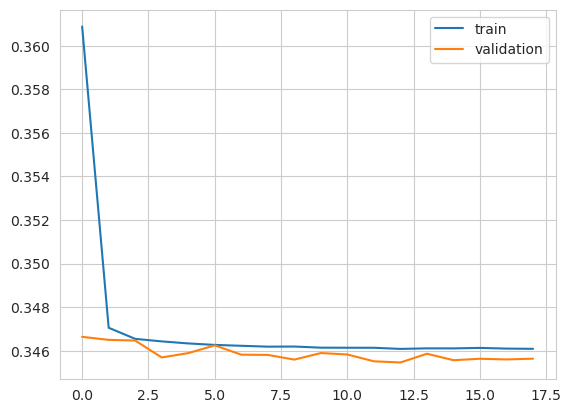

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [31]:
pred_df = pd.DataFrame(pred, columns=['TAG'])
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x >= 0.5 else 0)

In [32]:
pred_df['TAG'].value_counts()

1    200435
0     50115
Name: TAG, dtype: int64

In [33]:
classify = confusion_matrix(test_label, pred_df)
print(classify)

[[  2155    785]
 [ 47960 199650]]


In [34]:
p = precision_score(test_label, pred_df)
print("precision: %0.4f" %p)
r = recall_score(test_label, pred_df)
print("recall: %0.4f" %r)
f1 = f1_score(test_label, pred_df)
print("f1-score: %0.4f" %f1)
acc = accuracy_score(test_label, pred_df)
print("accuracy: %0.4f" %acc)

precision: 0.9961
recall: 0.8063
f1-score: 0.8912
accuracy: 0.8054
